## 0. Import Packages

In [3]:
import numpy as np
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import firedrake
from firedrake import Constant, inner, sqrt, tr, grad, div, as_vector, exp,sym, as_vector, dx, ds, Mesh, Function
import meshpy, meshpy.geometry, meshpy.triangle
import irksome
from irksome import Dt
from scipy.signal import detrend
import copy
import matplotlib
import irksome
from irksome import Dt
import matplotlib.pyplot as plt
import pandas as pd
import scipy

# %matplotlib widget

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

## 1. Create the initial mesh

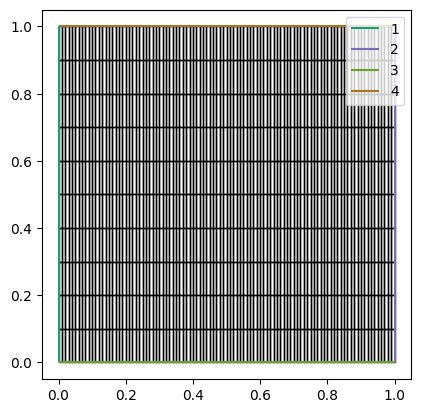

In [5]:
#Creating the initial mesh dimensions

nx, nz = 100, 10
initial_mesh = firedrake.UnitSquareMesh(nx, nz, quadrilateral=True)

fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(initial_mesh, axes=ax)
ax.legend();

### 1.1 Create a more reaslistic mesh

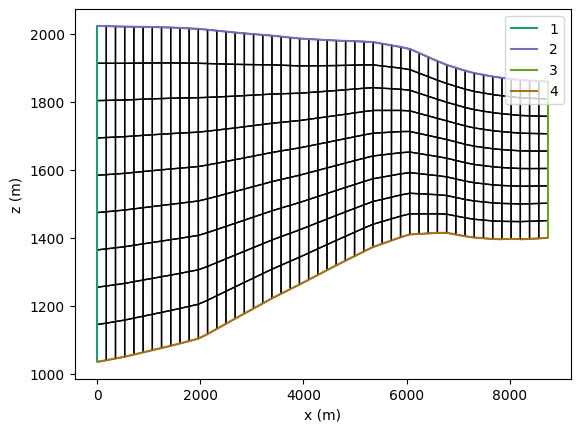

In [6]:
x, z = firedrake.SpatialCoordinate(initial_mesh)
mesh = Mesh('ALHIC1903_flowline_mesh_low_res_chopped.msh')
# Input the mesh dimensions here, not sure how to do this automatically
right_boundary_heights = []

for i in mesh.coordinates.dat.data:
    if i[0] == np.max(mesh.coordinates.dat.data[:,0]):
        right_boundary_heights.append(i[1])

depth = np.max(right_boundary_heights) - np.min(right_boundary_heights)

# length = 24000

# slope = (height_max - height_min) / length


x, z = firedrake.SpatialCoordinate(mesh)

bed_id = [4]
left_id = [1]
surface_id = [2]
right_id = [3]

fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
firedrake.triplot(mesh, axes=ax)
# ax.set_ylim([-100,100])
# ax.set_xlim([0,500])
ax.set_aspect("auto")
ax.legend();


### 2. Constants

In [7]:
# Constants
spy = 365.25 * 24 * 60 * 60
ρ = Constant(917.0)    # kg / m^3
c = Constant(2180)     # J / kg C
k = Constant(2.22)  # W / m C
α = (k/(ρ*c)) # diffusivity
A = 3.5e-25 
n = 3
R = 8.31446261815324
act_vol = -1.74e-5
Q = 6e4 # activatyion energy J/mol

dTdz = 2e-2 #C per 100m
geo_flux = Constant(46e-3) #W/m^2

λ = Constant(10.0)    # m
grav = Constant(-9.81) #m/s^2

vel_mpy = Constant(0.50) #m/yr
vel = vel_mpy / spy

# Surface condition
T_mean = -31 #average temp (C)
T_surface = Constant(T_mean) #

### 3. Build the pressure and velocity space

In [8]:

element = firedrake.FiniteElement("CG", "quadrilateral", 1)
V = firedrake.FunctionSpace(mesh, element)

T = firedrake.Function(V)
ϕ = firedrake.TestFunction(V)

In [9]:
pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
Y = velocity_space * pressure_space

y = firedrake.Function(Y)
u, p = firedrake.split(y)


μ = Constant(5e15) #Ice
# μ = Constant(1e14) #Test
def ε(u):
    return sym(grad(u))

v, q = firedrake.TestFunctions(y.function_space())

τ = 2 * μ * ε(u)
g = as_vector((0, grav))
f =  ρ * g

F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx

### 3.1 Boundary conditions

In [10]:
## We will say that the temperature is -30 at 2000 m 

temperature_expr = T_mean - (z - 2000)*.01

In [11]:
## Downward velocity at the divide, we will say is linear ##

w_s_divide = -0.05 / spy

divide_heights = []
for i in mesh.coordinates.dat.data:
    if i[0] == 0:
        divide_heights.append(i[1])

divide_depth = np.max(divide_heights) - np.min(divide_heights)

w_divide = w_s_divide * (((z - np.min(divide_heights)) / divide_depth))

In [12]:
## Downward velocity at the divide, we will say is linear ##

w_s_abl = 0.02 / spy

abl_boundary_heights = []

for i in mesh.coordinates.dat.data:
    if i[0] == np.max(mesh.coordinates.dat.data[:,0]):
        abl_boundary_heights.append(i[1])


abl_depth = np.max(abl_boundary_heights) - np.min(abl_boundary_heights)

w_abl = w_s_abl * (((z - np.min(abl_boundary_heights)) / abl_depth))

In [81]:
### For the case off the divide, we can force a parabolic shape ###

u_s_left = 0.05 / spy

left_heights = []
for i in mesh.coordinates.dat.data:
    if i[0] == 0:
        left_heights.append(i[1])

left_depth = np.max(left_heights) - np.min(left_heights)

u_left = u_s_left * (((z - np.min(left_heights)) / left_depth)**.33)

In [82]:
# velocity_profile_r = (0.05/spy) * (1-((z/depth))**(n+1)) #What is this velocity?
# velocity_profile_z = - accum * ((1+(z/depth))**(n+1))
# velocity_profile_surf = - accum * (1-(x/length/2))

bc_l = firedrake.DirichletBC(Y.sub(0), as_vector((u_left, 0)), left_id)
bc_r = firedrake.DirichletBC(Y.sub(0), as_vector((0, w_abl)), right_id)
bc_b = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0)), bed_id) 

#bc_r = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0)), right_id) 
# bc_s = firedrake.DirichletBC(Y.sub(0), as_vector((0, velocity_profile_surf)), [3]) # Not working

# bc_l = firedrake.DirichletBC(Y.sub(0), as_vector((velocity_profile, 0)), [1]) 

bc_stokes=[bc_l, bc_b, bc_r]
#bc_stokes=[bc_l, bc_r]
# bc_temp = [top_temp_bc]


### 4. Building the stokes solver

In [83]:
basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])

stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, bc_stokes)
parameters = {
    "nullspace": nullspace,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

stokes_solver.solve()

In [84]:
ϵ_dot = sym(grad(u))

In [85]:
# fig, axes = plt.subplots(figsize = [10,5])
# vel_field_plot = firedrake.tricontour(ϵ_dot, axes=axes);
# fig.colorbar(vel_field_plot)
# axes.set_ylabel('Depth (m)')
# axes.set_xlabel('Distance (m)')
# axes.set_title('Initial Stokes Solve')
# # axes.set_xlim([9000,10000])
# # axes.set_ylim([-1200,-800])
# plt.show()
# # fig.savefig('Test_model_flowfield.png')

In [86]:
# fig, axes = plt.subplots(figsize = [10,5])
# vel_field_plot = firedrake.quiver(y.sub(0).dat.data*spy, axes=axes, cmap="inferno", scale=3);

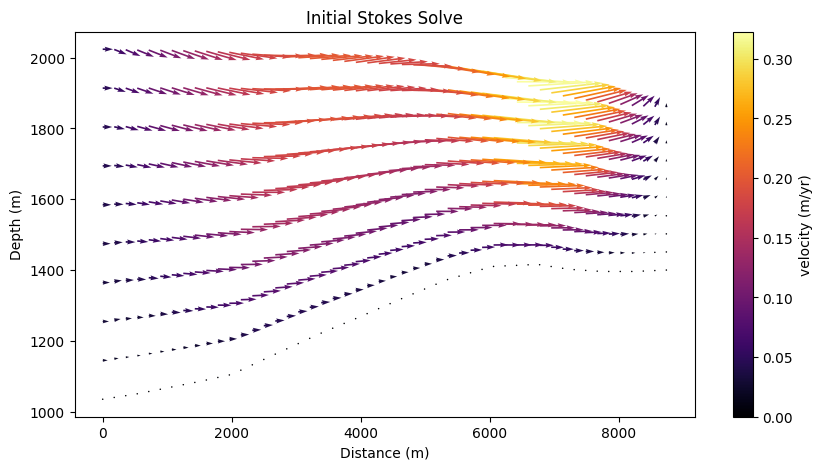

In [87]:
fig, axes = plt.subplots(figsize = [10,5])
vel_field_plot = firedrake.quiver(y.sub(0)*spy, axes=axes, cmap="inferno", scale=3);
fig.colorbar(vel_field_plot, label='velocity (m/yr)')
axes.set_ylabel('Depth (m)')
axes.set_xlabel('Distance (m)')
axes.set_title('Initial Stokes Solve')
# axes.set_xlim([9000,10000])
# axes.set_ylim([-1200,-800])
plt.show()
# fig.savefig('Test_model_flowfield.png')



/home/firedrake/firedrake/src/firedrake/firedrake/pyplot/mpl.py:218: UserWarning: The following kwargs were not used by contour: 'scale'
  return method(triangulation, toreal(values, complex_component), *args, **kwargs)


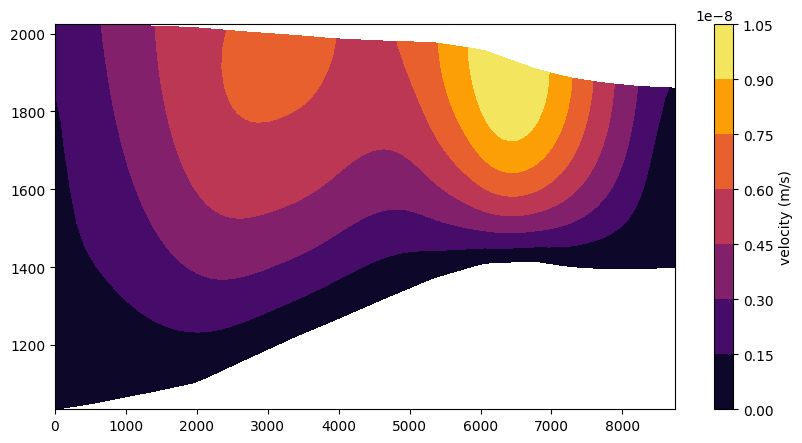

In [88]:
fig, axes = plt.subplots(figsize = [10,5])
vel_field_plot = firedrake.tricontourf(y.sub(0), axes=axes, cmap="inferno", scale=3);
fig.colorbar(vel_field_plot, label='velocity (m/s)')

/home/firedrake/firedrake/src/firedrake/firedrake/pyplot/mpl.py:218: UserWarning: The following kwargs were not used by contour: 'scale'
  return method(triangulation, toreal(values, complex_component), *args, **kwargs)


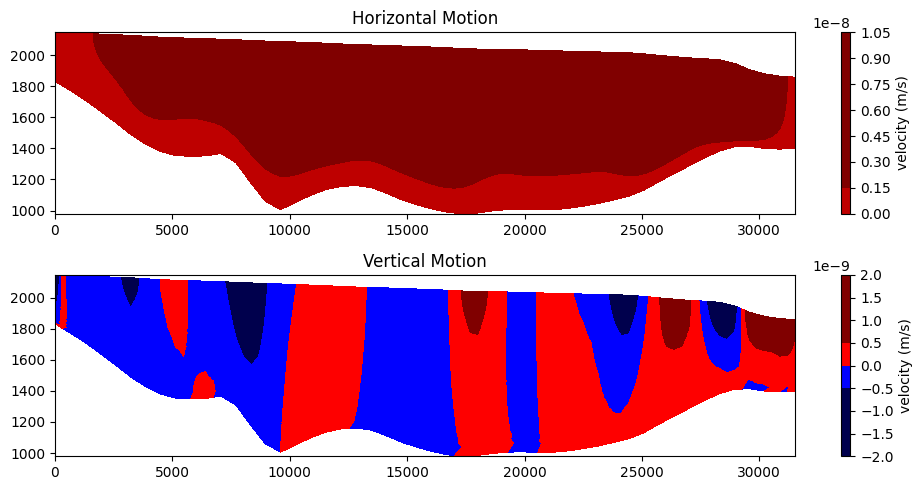

In [257]:
fig, (ax1, ax2)= plt.subplots(2,1, figsize = [10,5])
vel_field_plot1 = firedrake.tricontourf(y.sub(0).sub(0), axes=ax1, cmap="seismic", scale=3, vmin=-1e-9, vmax=1e-9);
vel_field_plot2 = firedrake.tricontourf(y.sub(0).sub(1), axes=ax2, cmap="seismic", scale=3, vmin=-5e-10, vmax=5e-10);
fig.colorbar(vel_field_plot1, label='velocity (m/s)', ax=ax1)
fig.colorbar(vel_field_plot2, label='velocity (m/s)', ax=ax2)

ax1.set_title('Horizontal Motion')

ax2.set_title('Vertical Motion')

plt.tight_layout()


In [258]:
# fig, axes = plt.subplots(figsize = [10,5])

# fig.colorbar(vel_field_plot, label='velocity (m/yr)')

### 5. Temperature

### 5.1 Just diffusion

In [259]:
geothermal_flux = -geo_flux*ϕ  * ds((bed_id[0]))

F = k * inner(grad(T), grad(ϕ)) * dx + geothermal_flux

# surf_bc = firedrake.DirichletBC(V, T_surface, surf_ids)
#surf_bc = firedrake.DirichletBC(V, T_surface+(slope / (1/100))*(1 + (x/length)), surface_id) #slope / (1/100) term is the dry adiabat following the slope
top_temp_bc = firedrake.DirichletBC(V, temperature_expr, surface_id)
bcs = [top_temp_bc]

firedrake.solve(F == 0, T, bcs)

### 5.2 Diffusion and advection

### 5.2.1 Construct the boundary conditions

In [260]:

# bcs_init = [upper_bc_init]

In [261]:
F_diffusion = k*inner(grad(T), grad(ϕ)) * dx
F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx

F_0 = F_advection + F_diffusion + geothermal_flux

top_temp_bc = firedrake.DirichletBC(V, temperature_expr, surface_id)
bcs = [top_temp_bc]
firedrake.solve(F_0 == 0, T, bcs)

In [275]:
T.dat.data.min()

-32.49

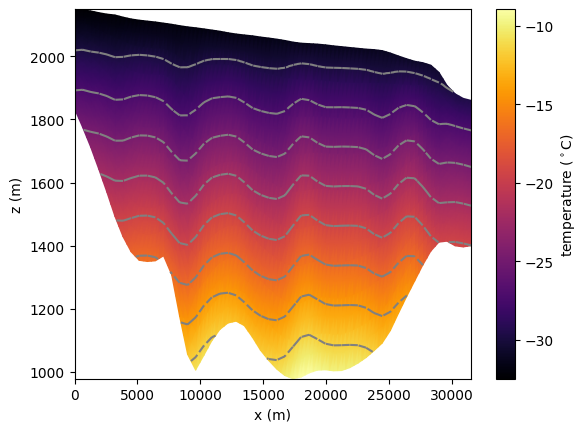

In [277]:
fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
colors = firedrake.tripcolor(T, cmap="inferno", axes=ax)
fig.colorbar(colors, label="temperature (${}^\circ$C)")
levels = np.linspace(T.dat.data.min(), T.dat.data.max(), 10)
firedrake.tricontour(T, levels=levels, colors="grey", axes=ax)
# ax.set_xlim([9000,10000]);

### Compare to boreholes

In [199]:
borehole_locs = pd.read_csv("Borehole_locations_distance.csv")
borehole_loc = borehole_locs[borehole_locs['Borehole'] == 'ALHIC1903']

x_loc = borehole_loc["Borehole_Distance"].values[0]
y_values = np.linspace(np.min(mesh.coordinates.dat.data[:,1]), np.max(mesh.coordinates.dat.data[:,1]), 50)

In [209]:
## Get nearest x location in mesh ##

x_nearest = find_nearest(mesh.coordinates.dat.data[:,0],x_loc)

In [226]:
borehole_mesh_values = []

for i in mesh.coordinates.dat.data:

    if x_nearest - 6 < i[0] < x_nearest + 6:
        print(i)
        borehole_mesh_values.append(i)

[29590.78663523  1907.60224151]
[29590.19380492  1852.77614439]
[29589.60097462  1797.95004727]
[29589.00814431  1743.12395016]
[29588.415314    1688.29785304]
[29587.8224837   1633.47175592]
[29587.22965339  1578.6456588 ]
[29586.63682309  1523.81956169]
[29586.04399278  1468.99346457]
[29585.45116247  1414.16736745]


In [230]:
borehole_temp_model = []
borehole_y_val = []

for x_val, y_val in borehole_mesh_values:
    point = (x_val, y_val)
    borehole_temp_model.append(T.at(point))
    borehole_y_val.append(y_val)

In [282]:
velocity_profile = []
borehole_y_val = []

for x_val, y_val in borehole_mesh_values:
    point = (x_val, y_val)
    velocity_profile.append(y.sub(0).at(point))
    borehole_y_val.append(y_val)

velocity_profile = np.array(velocity_profile)

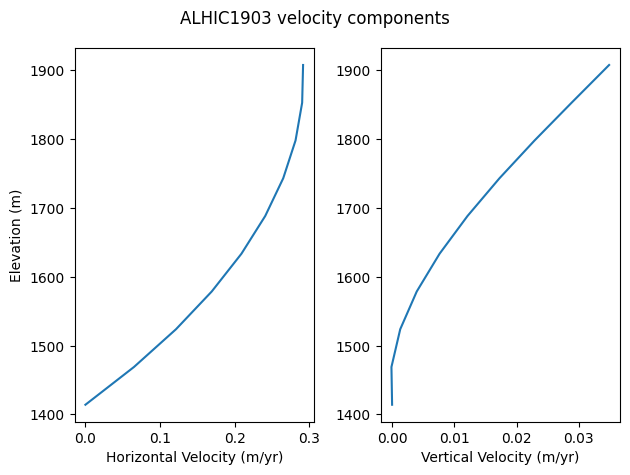

In [286]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(velocity_profile[:,0]*spy, borehole_y_val)
ax2.plot(velocity_profile[:,1]*spy, borehole_y_val)

ax1.set_ylabel('Elevation (m)')
ax1.set_xlabel('Horizontal Velocity (m/yr)')
ax2.set_xlabel('Vertical Velocity (m/yr)')
fig.suptitle('ALHIC1903 velocity components')
plt.tight_layout()

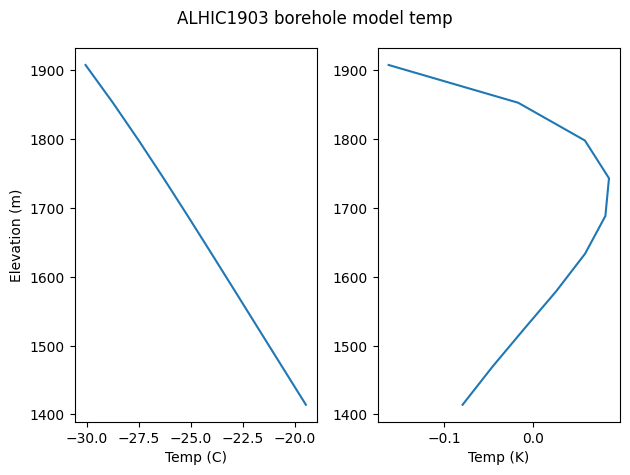

In [279]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(borehole_temp_model, borehole_y_val)
ax2.plot(scipy.signal.detrend(borehole_temp_model), borehole_y_val)

ax1.set_ylabel('Elevation (m)')
ax1.set_xlabel('Temp (C)')
ax2.set_xlabel('Temp (K)')
fig.suptitle('ALHIC1903 borehole model temp')
plt.tight_layout()

In [2]:
# pick a flowline. Plot a profile and flow all the way up to the divide. 
# then plot one with a shorter domain just near the borehole and try various flow forcings on the left.

### 5.3 New A parameter

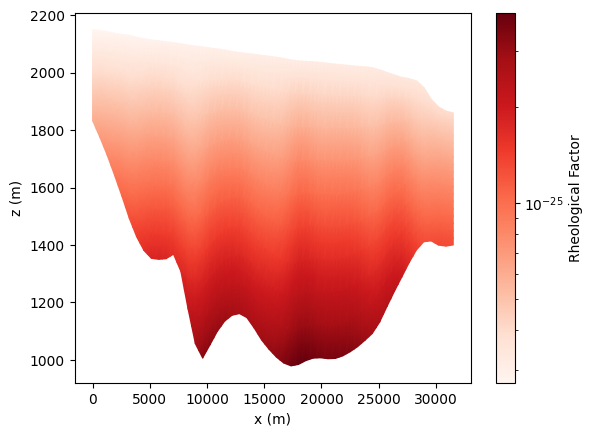

In [238]:
### TODO: FIX THIS VALUE ###
# A_new = A*exp(-((Q + (p*act_vol))/((T+273.15)*R)))

A_new = A*exp(-(Q/R*( 1/(T+273.15) - 1/263))) #Does not account for melting point depression

#A_new = A*exp((-Q/R)*(1/T - 1/263))
A_new_field = Function(V).project(A_new)

fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
colors = firedrake.tripcolor(A_new_field, cmap="Reds", axes=ax, norm=matplotlib.colors.LogNorm())
fig.colorbar(colors, label='Rheological Factor')

### 6. Calculate a new visocity and rate factor A

0.19189056830379975
0.1820194585275359
0.15982251323423843
0.1274349301844882
0.09106744028054448
0.062228013918209375
0.04106244806815117
0.026434378123296794
0.016772546376878018
0.010539396029260864
0.006580716601105983


/tmp/ipykernel_3808/3675478462.py:107: RuntimeWarning: invalid value encountered in divide
  vx_normalized = vx / magnitudes
/tmp/ipykernel_3808/3675478462.py:108: RuntimeWarning: invalid value encountered in divide
  vy_normalized = vy / magnitudes


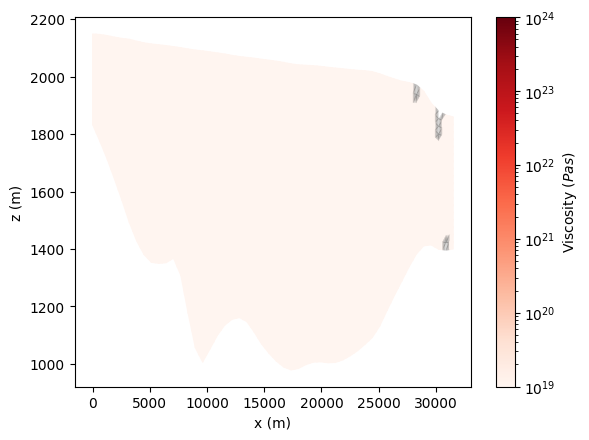

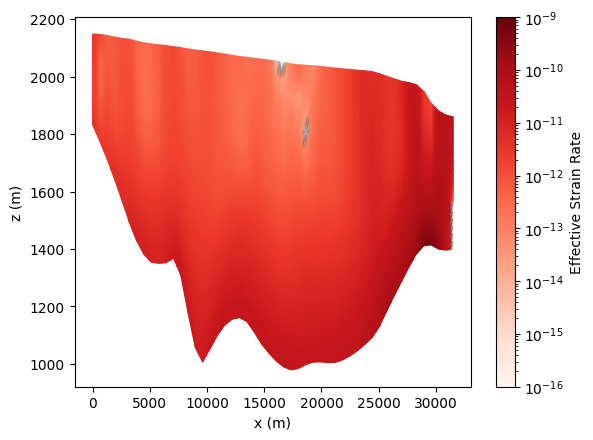

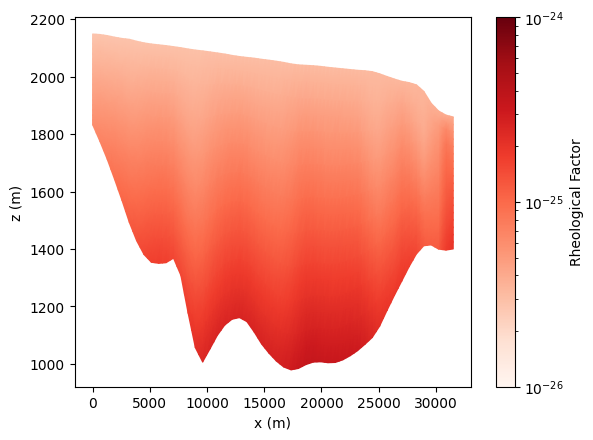

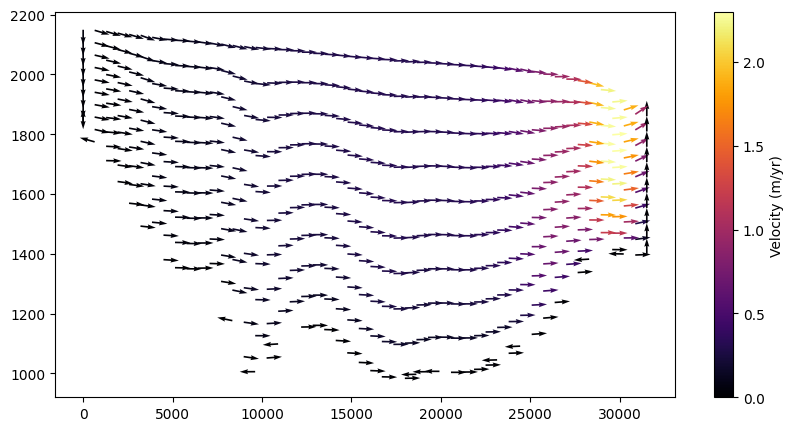

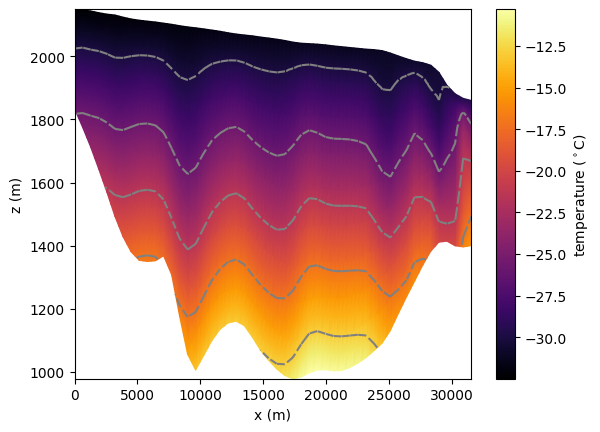

In [239]:
velocity_field = y.sub(0).dat.data
temp_field = T.dat.data

for i in range(100):
    prev_temp_field = copy.deepcopy(temp_field)
    prev_velocity = copy.deepcopy(velocity_field)
    ϵ_ = sym(grad(u))
    
    ϵ_effective = sqrt((inner(ϵ_, ϵ_)+tr(ϵ_)**2)*0.5)
    
    # A_new = A*exp(-((Q + (p*act_vol))/((T+273.15)*R)))

    A_new = A*exp(-(Q/R*( 1/(T+273.15) - 1/263))) #Does not account for melting point depression
    μ_new =  0.5*(A_new**(-1/n))*(ϵ_effective**((1/n)-1))
    
    μ_new_field = Function(V).project(μ_new)
    ϵ_effective_field = Function(V).project(ϵ_effective)
    A_new_field = Function(V).project(A_new)

    def ε(u):
        return sym(grad(u))
    
    ### Build the stokes flow model ###
    
    pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
    velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
    Y = velocity_space * pressure_space
    
    y = firedrake.Function(Y)
    u, p = firedrake.split(y)
    v, q = firedrake.TestFunctions(y.function_space())
    
    τ = 2* μ_new * ε(u)#  2 * μ_new_field *  ϵ_
    g = as_vector((0, grav))
    f =  ρ * g
    
    F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx

    basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
    nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])

    stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, bc_stokes)
    parameters = {
        "nullspace": nullspace,
        "solver_parameters": {
            "ksp_type": "preonly",
            "pc_type": "lu",
            "pc_factor_mat_solver_type": "mumps",
        },
    }
    stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

    stokes_solver.solve()

    
    ### Get the new velocity field solved for ###
    velocity_field = y.sub(0).dat.data


    
    ### Build the temperature model ###
    
    F_diffusion = k*inner(grad(T), grad(ϕ)) * dx
    F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx
    geothermal_flux = -geo_flux*ϕ  * ds((bed_id[0]))
 
    F_0 = F_advection + F_diffusion + geothermal_flux

    ### Solve for the temperature field
    firedrake.solve(F_0 == 0, T, bcs)

    ### Get the new temp field we just solved for ###
    temp_field = T.dat.data

    ### Calculate the residuals in the temp field ###
    residual = np.sum(np.abs((prev_temp_field - temp_field)))/temp_field.shape[0]
    print(residual)
    if residual < 0.01: #If the residual is less than the 0.01 m/yr, let's call it good.
        fig, ax = plt.subplots()
        ax.set_aspect("auto")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("z (m)")
        colors = firedrake.tripcolor(μ_new_field, cmap="Reds", axes=ax,  norm=matplotlib.colors.LogNorm(vmin=1e19, vmax=1e24))
        fig.colorbar(colors, label='Viscosity ($Pa s$)')

        fig, ax = plt.subplots()
        ax.set_aspect("auto")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("z (m)")
        colors = firedrake.tripcolor(ϵ_effective_field, cmap="Reds", axes=ax, norm=matplotlib.colors.LogNorm(vmin=1e-16,vmax=1e-9))
        fig.colorbar(colors, label='Effective Strain Rate')
        
        fig, ax = plt.subplots()
        ax.set_aspect("auto")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("z (m)")
        colors = firedrake.tripcolor(A_new_field, cmap="Reds", axes=ax, norm=matplotlib.colors.LogNorm(vmin=1e-26, vmax=1e-24))
        fig.colorbar(colors, label='Rheological Factor')
        # Extract the vector field components and coordinates
        x_ex, y_ex = mesh.coordinates.dat.data.T
        # Interpolate the vector field at mesh vertices
        vx = np.array([y.sub(0).at([x_ex[i], y_ex[i]])[0] for i in range(len(x_ex))])
        vy = np.array([y.sub(0).at([x_ex[i], y_ex[i]])[1] for i in range(len(y_ex))])
        
        # Compute magnitudes and normalize vectors to have unit length
        magnitudes = np.sqrt(vx**2 + vy**2)
        vx_normalized = vx / magnitudes
        vy_normalized = vy / magnitudes
        fig, axes = plt.subplots(figsize = [10,5])
        vel_plot = plt.quiver(x_ex, y_ex, vx_normalized, vy_normalized, magnitudes*spy,cmap="inferno") # Adjust 'scale' as needed for visibility
        plt.colorbar(vel_plot, label="Velocity (m/yr)")

        fig, ax = plt.subplots()
        ax.set_aspect("auto")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("z (m)")
        colors = firedrake.tripcolor(T, cmap="inferno", axes=ax)
        fig.colorbar(colors, label="temperature (${}^\circ$C)")
        levels = np.linspace(-30, 0, 8)
        firedrake.tricontour(T, levels=levels, colors="grey", axes=ax)
        # ax.set_xlim([9000,10000]);
        break


In [72]:
# pressure_field = Function(V).project(p)

# fig, ax = plt.subplots()
# ax.set_aspect("auto")
# ax.set_xlabel("x (m)")
# ax.set_ylabel("z (m)")
# colors = firedrake.tripcolor(pressure_field, cmap="Reds", axes=ax, norm=matplotlib.colors.LogNorm(vmin = 2e7, vmax = 4e7))
# fig.colorbar(colors)